In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
cifar10_full = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=False, transform=transform_train)
train_size = int(0.9 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
cifar10_train, cifar10_val = random_split(cifar10_full, [train_size, val_size])

cifar10_test = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=False, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# BasicBlock for ResNet-11
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# Definition of ResNet-11
class ResNet11(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet11, self).__init__()
        self.in_channels = 64
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        # Four layers with 1 block each: [1, 1, 1, 1]
        self.layer1 = self._make_layer(64, 1, stride=1)
        self.layer2 = self._make_layer(128, 1, stride=2)
        self.layer3 = self._make_layer(256, 1, stride=2)
        self.layer4 = self._make_layer(512, 1, stride=2)
        # Global average pooling and final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * BasicBlock.expansion, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels  # update channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
# load model
model = ResNet11(num_classes=10).to(device)
print(model)

ResNet11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected AlexNet parameter count:", count_parameters(model))

Selected AlexNet parameter count: 4903242


In [6]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: Train Loss: 1.3948, Val Loss: 1.3577, Val Acc: 0.5490
Epoch 2/30: Train Loss: 0.9558, Val Loss: 0.8933, Val Acc: 0.6804
Epoch 3/30: Train Loss: 0.7617, Val Loss: 0.7263, Val Acc: 0.7384
Epoch 4/30: Train Loss: 0.6496, Val Loss: 0.7537, Val Acc: 0.7358
Epoch 5/30: Train Loss: 0.5718, Val Loss: 0.5448, Val Acc: 0.8092
Epoch 6/30: Train Loss: 0.5128, Val Loss: 0.6399, Val Acc: 0.7782
Epoch 7/30: Train Loss: 0.4666, Val Loss: 0.5961, Val Acc: 0.7988
Epoch 8/30: Train Loss: 0.4219, Val Loss: 0.4901, Val Acc: 0.8310
Epoch 9/30: Train Loss: 0.3945, Val Loss: 0.4903, Val Acc: 0.8236
Epoch 10/30: Train Loss: 0.3581, Val Loss: 0.4933, Val Acc: 0.8374
Epoch 11/30: Train Loss: 0.3364, Val Loss: 0.4090, Val Acc: 0.8556
Epoch 12/30: Train Loss: 0.3139, Val Loss: 0.3838, Val Acc: 0.8676
Epoch 13/30: Train Loss: 0.2882, Val Loss: 0.3740, Val Acc: 0.8696
Epoch 14/30: Train Loss: 0.2709, Val Loss: 0.3909, Val Acc: 0.8686
Epoch 15/30: Train Loss: 0.2530, Val Loss: 0.3846, Val Acc: 0.8738
Epoc

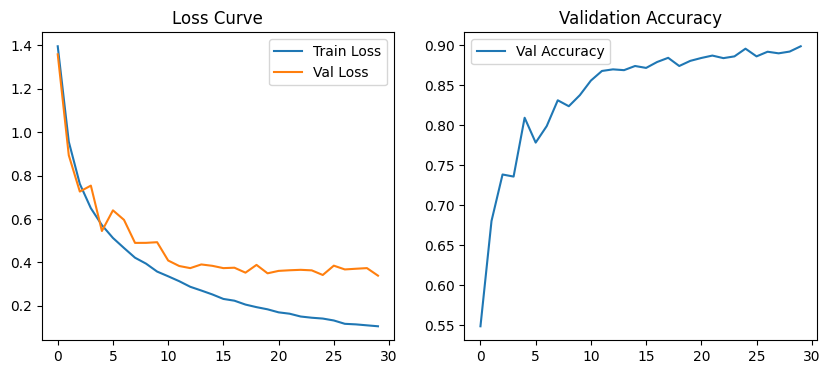

In [7]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p3_10_ResNet11_results.png")
plt.show()

In [8]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [9]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar10_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.8987857489757158
Test Recall: 0.896
Test F1 Score: 0.8968423659047041

Confusion Matrix:
 [[915   5  24  15   7   1   4   0  17  12]
 [  9 948   1   7   0   0   0   1   8  26]
 [ 25   0 860  33  30  30  19   1   1   1]
 [  7   0  28 833  27  74  19   6   4   2]
 [  7   0  22  29 899  17  18   6   1   1]
 [  4   1  10 104  19 851   4   7   0   0]
 [  5   1  26  33   8  11 914   1   0   1]
 [ 15   1   8  43  25  23   3 876   2   4]
 [ 33   6   5   4   0   1   2   0 941   8]
 [ 16  36   1  10   0   3   1   0  10 923]]

Classification Report:
               precision    recall  f1-score   support

    airplane       0.88      0.92      0.90      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.87      0.86      0.87      1000
         cat       0.75      0.83      0.79      1000
        deer       0.89      0.90      0.89      1000
         dog       0.84      0.85      0.85      1000
        frog       0.93      0.91      0.92      1000
   

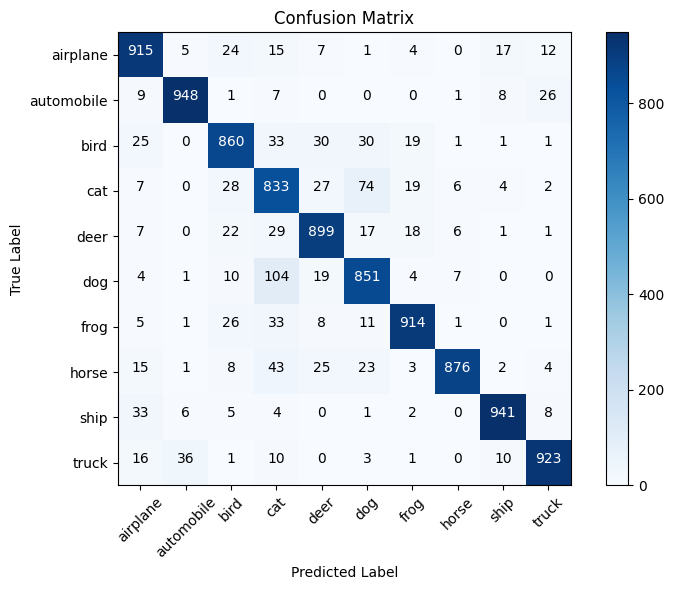

In [10]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar10_test.classes))
plt.xticks(tick_marks, cifar10_test.classes, rotation=45)
plt.yticks(tick_marks, cifar10_test.classes)

# Annotate the confusion matrix cells with the numeric values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p3_10_ResNet11_matrix.png")
plt.show()